In [1]:
!pip install kagglehub
!pip install transformers
!pip install torch torchvision
!pip install pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("vishmiperera/children-drawings")
print("Dataset downloaded to:", path)


100%|██████████| 41.3M/41.3M [00:00<00:00, 177MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/vishmiperera/children-drawings/versions/1


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

base_path = "/content/drive/MyDrive/archive-3"
for item in os.listdir(base_path):
    print("📁", item)

📁 NewArts2
📁 data


In [8]:
import os
import pandas as pd
from PIL import Image
from transformers import pipeline
from tqdm import tqdm

# Load CLIP model (good with images+text)
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# Human-readable prompts for drawings
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]

# Corresponding emotion labels for output
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]

# Map verbose prompt back to class label
prompt_to_label = dict(zip(prompt_labels, emotion_labels))

# Dataset base path
base_path = "/content/drive/MyDrive/archive-3"
source = "data"

# Results container
results = []

# Process each labeled folder
for label in emotion_labels:
    folder_path = os.path.join(base_path, source, label)

    if not os.path.exists(folder_path):
        print(f"⚠️ Skipping missing folder: {folder_path}")
        continue

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

    for image_name in tqdm(image_files, desc=f"{source}/{label}"):
        image_path = os.path.join(folder_path, image_name)

        try:
            image = Image.open(image_path).convert("RGB")
            prediction = classifier(image, candidate_labels=prompt_labels, top_k=1)[0]

            results.append({
                "image_path": image_path,
                "actual_label": label,
                "predicted_label": prompt_to_label[prediction["label"]],
                "confidence": prediction["score"]
            })
        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")


Device set to use cpu
data/Fear: 100%|██████████| 68/68 [00:29<00:00,  2.28it/s]


In [9]:
df = pd.DataFrame(results)
csv_path = "/content/drive/MyDrive/drawing_emotion_predictions_prompted.csv"
df.to_csv(csv_path, index=False)
print("✅ Results saved to:", csv_path)


✅ Results saved to: /content/drive/MyDrive/drawing_emotion_predictions_prompted.csv


In [10]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/drawing_emotion_predictions_prompted.csv")
df.head()


,image_path,actual_label,predicted_label,confidence
0,/content/drive/MyDrive/archive-3/data/Happy/ne...,Happy,Happy,0.814903
1,/content/drive/MyDrive/archive-3/data/Happy/ne...,Happy,Happy,0.732911
2,/content/drive/MyDrive/archive-3/data/Happy/ne...,Happy,Happy,0.652640
3,/content/drive/MyDrive/archive-3/data/Happy/ne...,Happy,Happy,0.660409
4,/content/drive/MyDrive/archive-3/data/Happy/h3...,Happy,Happy,0.958294


In [11]:
 accuracy = (df["actual_label"] == df["predicted_label"]).mean()
print(f"✅ Prompt-based classification accuracy: {accuracy:.2%}")


✅ Prompt-based classification accuracy: 61.83%


In [16]:
from PIL import Image
from transformers import pipeline

# Prompt-engineered labels for drawings
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]

# Map back to class names
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))

# Load CLIP classifier
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# Load the image
image_path = "/content/f97.jpeg"
image = Image.open(image_path).convert("RGB")

# Run classification
result = classifier(image, candidate_labels=prompt_labels, top_k=1)[0]

# Output result
predicted_emotion = prompt_to_label[result["label"]]
confidence = result["score"]
print(f"🎨 Predicted Emotion: {predicted_emotion} ({confidence:.2%} confidence)")


Device set to use cpu


🎨 Predicted Emotion: Fear (71.51% confidence)


In [1]:
from PIL import Image
from transformers import pipeline

# Prompt-engineered labels for drawings
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]

# Map back to class names
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))

# Load CLIP classifier
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# Load the image
image_path = "/content/f97.jpeg"
image = Image.open(image_path).convert("RGB")

# Run classification
result = classifier(image, candidate_labels=prompt_labels, top_k=1)[0]

# Output result
predicted_emotion = prompt_to_label[result["label"]]
confidence = result["score"]
print(f"🎨 Predicted Emotion: {predicted_emotion} ({confidence:.2%} confidence)")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


🎨 Predicted Emotion: Fear (71.51% confidence)


In [2]:
from PIL import Image, ImageDraw, ImageFont
from transformers import pipeline
import matplotlib.pyplot as plt

# === Step 1: Setup ===
image_path = "/content/f97.jpeg"

# Prompt labels for CLIP (child drawing context)
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))

# Load image + CLIP classifier
image = Image.open(image_path).convert("RGB")
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# === Step 2: Run Classification ===
result = classifier(image, candidate_labels=prompt_labels, top_k=1)[0]
predicted_emotion = prompt_to_label[result["label"]]
confidence = result["score"]
print(f"🎨 Emotion: {predicted_emotion} ({confidence:.2%} confidence)")


Device set to use cpu


🎨 Emotion: Fear (71.51% confidence)


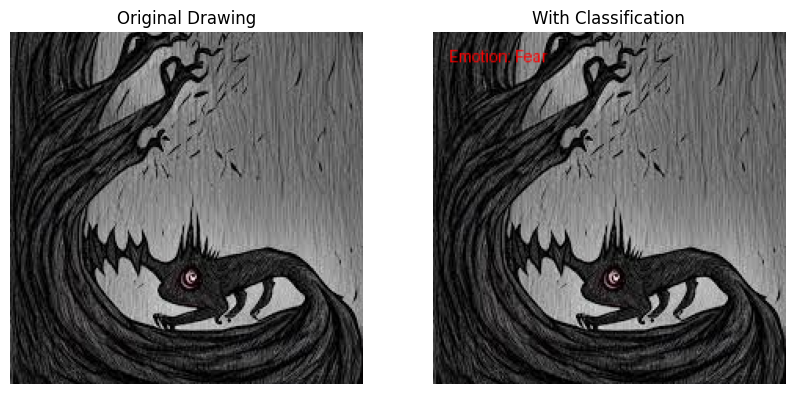

In [3]:
# Annotate image with predicted label
annotated = image.copy()
draw = ImageDraw.Draw(annotated)

# Add label on image
label_text = f"Emotion: {predicted_emotion}"
draw.text((10, 10), label_text, fill="red")

# Show original and annotated
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Drawing")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("With Classification")
plt.imshow(annotated)
plt.axis("off")
plt.show()


In [4]:
# Generate prompt for GPT
story_prompt = (
    f"This is a drawing made by a child. It seems to express the emotion: {predicted_emotion}. "
    "Write a short, warm, and imaginative story or interpretation explaining why the child might feel this way. "
    "Make it understandable and comforting to a parent."
)

# Use Hugging Face GPT2 if no OpenAI key
generator = pipeline("text-generation", model="gpt2-medium")
story = generator(story_prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]

# Show result
print("\n📝 Generated Interpretation:\n")
print(story)


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



📝 Generated Interpretation:

This is a drawing made by a child. It seems to express the emotion: Fear. Write a short, warm, and imaginative story or interpretation explaining why the child might feel this way. Make it understandable and comforting to a parent. You can write a child cry like this as a symbol for love. This drawing was made by a child.


This is a drawing made by a child. It seems to express the emotion: Anger. Write a short, warm, and imaginative story or interpretation


In [5]:
!pip install transformers
!pip install git+https://github.com/salesforce/BLIP
!pip install timm


  Cloning https://github.com/salesforce/BLIP to /tmp/pip-req-build-gczbroxm
  Running command git clone --filter=blob:none --quiet https://github.com/salesforce/BLIP /tmp/pip-req-build-gczbroxm
  Resolved https://github.com/salesforce/BLIP to commit 3a29b7410476bf5f2ba0955827390eb6ea1f4f9d
ERROR: git+https://github.com/salesforce/BLIP does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 776.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [6]:
from PIL import Image
from transformers import pipeline
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# === Load image captioning model (BLIP) ===
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# === Load CLIP zero-shot classifier ===
clip_classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# === Prompts ===
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Device set to use cpu


In [7]:
# Load image
image_path = "/content/f97.jpeg"
raw_image = Image.open(image_path).convert("RGB")

# === Emotion Classification ===
emotion_result = clip_classifier(raw_image, candidate_labels=prompt_labels, top_k=1)[0]
predicted_emotion = prompt_to_label[emotion_result["label"]]
print(f"🎯 Emotion: {predicted_emotion}")

# === Image Captioning (BLIP) ===
inputs = blip_processor(raw_image, return_tensors="pt")
out = blip_model.generate(**inputs)
caption = blip_processor.decode(out[0], skip_special_tokens=True)
print(f"🖼️ Caption: {caption}")


🎯 Emotion: Fear
🖼️ Caption: a black and white drawing of a dragon with red eyes


In [8]:
# Combine into final message
explanation = (
    f"This drawing seems to express **{predicted_emotion.lower()}**.\n"
    f"The child appears to have drawn: *{caption}*.\n"
    f"This might suggest the child is feeling {predicted_emotion.lower()}, "
    f"possibly because of what they imagined or experienced recently."
)

print("\n🧠 Interpretation for a parent:\n")
print(explanation)



🧠 Interpretation for a parent:

This drawing seems to express **fear**.
The child appears to have drawn: *a black and white drawing of a dragon with red eyes*.
This might suggest the child is feeling fear, possibly because of what they imagined or experienced recently.


In [9]:
from PIL import Image, ImageDraw, ImageFont
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import torch
import os

# ===== Load models once =====
# Emotion classifier (CLIP)
clip_classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# Captioning model (BLIP)
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Emotion prompts and mapping
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))


# ===== Function: Classify Emotion =====
def classify_emotion(image):
    result = clip_classifier(image, candidate_labels=prompt_labels, top_k=1)[0]
    return prompt_to_label[result["label"]], result["score"]

# ===== Function: Generate Caption =====
def caption_image(image):
    inputs = blip_processor(image, return_tensors="pt")
    out = blip_model.generate(**inputs)
    return blip_processor.decode(out[0], skip_special_tokens=True)


Device set to use cpu


In [10]:
def interpret_child_drawing(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Step 1: Caption it
    caption = caption_image(image)

    # Step 2: Classify emotion
    emotion, confidence = classify_emotion(image)

    # Step 3: Overlay image with caption + emotion
    annotated = image.copy()
    draw = ImageDraw.Draw(annotated)
    font_size = 18
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    draw.text((10, 10), f"Emotion: {emotion}", fill="red", font=font)
    draw.text((10, 35), f"Caption: {caption}", fill="blue", font=font)

    # Step 4: Display
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated)
    plt.axis("off")
    plt.title("Child Drawing Interpretation")
    plt.show()

    # Step 5: Final message
    print(f"🖼️ Caption: {caption}")
    print(f"🎯 Emotion: {emotion} ({confidence:.2%})")
    print(f"📘 Interpretation: This child seems to express **{emotion.lower()}**. "
          f"The drawing shows: '{caption}', which might reflect their emotional state.")


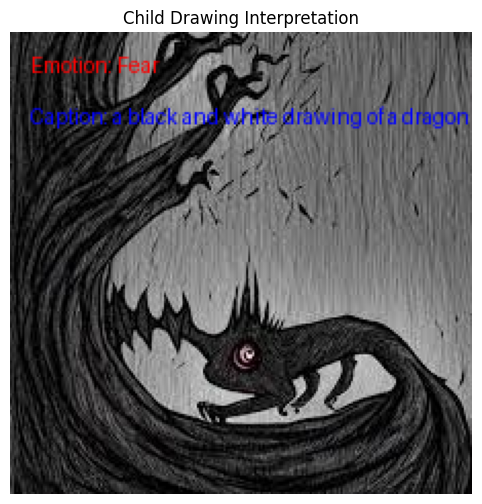

🖼️ Caption: a black and white drawing of a dragon with red eyes
🎯 Emotion: Fear (71.51%)
📘 Interpretation: This child seems to express **fear**. The drawing shows: 'a black and white drawing of a dragon with red eyes', which might reflect their emotional state.


In [11]:
# Use this to run your full system
interpret_child_drawing("/content/f97.jpeg")


In [14]:
import pandas as pd

# Load your saved predictions
df = pd.read_csv("/content/drive/MyDrive/drawing_emotion_predictions_prompted.csv")

# Accuracy
accuracy = (df["actual_label"] == df["predicted_label"]).mean()
print(f"✅ Model Accuracy: {accuracy:.2%}")


✅ Model Accuracy: 61.83%


In [15]:
from PIL import Image, ImageDraw, ImageFont
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import torch
import os

# ===== Load models once =====
# Emotion classifier (CLIP)
clip_classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")

# Captioning model (BLIP)
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Emotion prompts and mapping
prompt_labels = [
    "A drawing made by a child showing happiness",
    "A drawing made by a child showing sadness",
    "A drawing made by a child showing anger",
    "A drawing made by a child showing fear"
]
emotion_labels = ["Happy", "Sad", "Angry", "Fear"]
prompt_to_label = dict(zip(prompt_labels, emotion_labels))


# ===== Function: Classify Emotion =====
def classify_emotion(image):
    result = clip_classifier(image, candidate_labels=prompt_labels, top_k=1)[0]
    return prompt_to_label[result["label"]], result["score"]

# ===== Function: Generate Caption =====
def caption_image(image):
    inputs = blip_processor(image, return_tensors="pt")
    out = blip_model.generate(**inputs)
    return blip_processor.decode(out[0], skip_special_tokens=True)


Device set to use cpu


In [16]:
def interpret_child_drawing(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Step 1: Caption it
    caption = caption_image(image)

    # Step 2: Classify emotion
    emotion, confidence = classify_emotion(image)

    # Step 3: Overlay image with caption + emotion
    annotated = image.copy()
    draw = ImageDraw.Draw(annotated)
    font_size = 18
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    draw.text((10, 10), f"Emotion: {emotion}", fill="red", font=font)
    draw.text((10, 35), f"Caption: {caption}", fill="blue", font=font)

    # Step 4: Display
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated)
    plt.axis("off")
    plt.title("Child Drawing Interpretation")
    plt.show()

    # Step 5: Final message
    print(f"🖼️ Caption: {caption}")
    print(f"🎯 Emotion: {emotion} ({confidence:.2%})")
    print(f"📘 Interpretation: This child seems to express **{emotion.lower()}**. "
          f"The drawing shows: '{caption}', which might reflect their emotional state.")


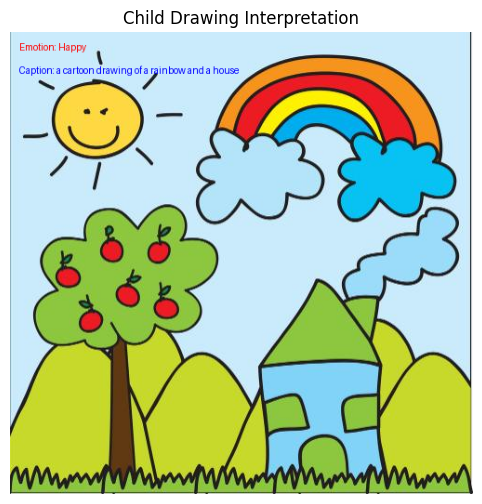

🖼️ Caption: a cartoon drawing of a rainbow and a house
🎯 Emotion: Happy (87.07%)
📘 Interpretation: This child seems to express **happy**. The drawing shows: 'a cartoon drawing of a rainbow and a house', which might reflect their emotional state.


In [17]:
# Use this to run your full system
interpret_child_drawing("/content/h3.jpg")
